In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib as plt

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor

In [2]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [3]:
##Update this, its probably not where your DB is
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v4.db')


Get the on scene time and response time from calls for service, join it to the catchment output to get zone_idx, accessibiliy, also getting primary situation index

In [4]:
    cur = con.cursor()

    df = pd.read_sql("select calls_for_service.analysis_neighborhoods as neighborhood " \
        ", calls_for_service.call_number " \
        ", calls_for_service.incident_number " \
        ", floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        ", category_mappings.[index] as primary_situation_index " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "left join fire_incidents AS fi on calls_for_service.incident_number = fi.incident_number " \
        "left join category_mappings on fi.primary_situation = category_mappings.primary_situation " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con) 

In [5]:
df.head()

,neighborhood,call_number,incident_number,index,zone_idx,accessibility_score,scenario_name,on_scene_dttm,response_dttm,primary_situation_index
0,29.0,190012684,19000313,0,8,0.000803,baseline,2019-01-01 16:25:28,01/01/2019 04:22:21 PM,NaN
1,29.0,190012684,19000313,0,8,0.000803,baseline,2019-01-01 16:23:04,01/01/2019 04:18:06 PM,NaN
2,29.0,190022379,19000734,0,8,0.000803,baseline,2019-01-02 15:35:57,01/02/2019 03:31:21 PM,NaN
3,29.0,190053013,19002138,0,8,0.000803,baseline,2019-01-05 20:41:37,01/05/2019 08:40:16 PM,NaN
4,29.0,190060098,19002211,0,8,0.000803,baseline,2019-01-06 00:54:34,01/06/2019 12:52:49 AM,148.0


In [30]:
#do some date math
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds) 
df['day_of_week'] = df['on_scene_dttm'].dt.dayofweek
df['dayflag'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)

df = df[df['dayflag'].notna()]
df = df[df['day_of_week'].notna()]

In [65]:
#rool up accessibility and minutes to zone
df_ag = df.groupby(["zone_idx","day_of_week", "dayflag"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
print(len(df_ag))
df_ag.head()

3515


,zone_idx,day_of_week,dayflag,accessibility_score,minutes
0,8,0.0,False,0.000803,7.283333
1,8,0.0,True,0.000803,7.289506
2,8,1.0,False,0.000803,2.916667
3,8,1.0,True,0.000803,14.403333
4,8,2.0,False,0.000803,3.583333


In [91]:
# hide the warings.
# I mean if it was really important it would just be an error, so blissfully ignore
warnings.filterwarnings('ignore')

# set the training variables
df_ag.target_to_predict = 'minutes'
df_ag.predictors = ['zone_idx', 'day_of_week', 'dayflag', 'accessibility_score']

df_ag.x = df_ag[df_ag.predictors].values
df_ag.y = df_ag[df_ag.target_to_predict].values

df_ag.x_train, df_ag.x_test, df_ag.y_train, df_ag.y_test = train_test_split(df_ag.x, df_ag.y, test_size=0.8, random_state=42)



In [93]:
#copy/paste code:

def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=4000, subsample=0.9, colsample_bynode=0.2)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('md.ytest', md.y_test)
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')



XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=0.2, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=None,
               missing=nan, monotone_constraints=None, n_estimators=4000,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.9,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.30300739787979436
md.ytest [2.68459596 4.14375    4.22727273 ... 3.64583333 3.36666667 3.05      ]
Accuracy 74.08628914017433
Accuracy -inf


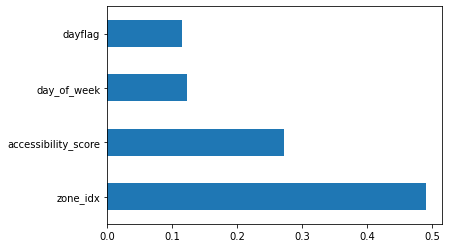

In [111]:
create_model(df_ag)

In [116]:
#Get data to predict
cur = con.cursor()
scenario_name = "new_station_235"
day_of_week = 3
dayFlag = True
df_to_predict = pd.read_sql(('select zone_idx, accessibility_score, ? as day_of_week, ? as dayflag from simulation_floating_catchment_output where scenario_name = ?'), con=con,params=[day_of_week, dayFlag, scenario_name])
#assumptions
df_to_predict["dayflag"] = dayFlag
df_to_predict["day_of_week"] = day_of_week
print(df_to_predict.head())
print(df_to_predict.count())

   zone_idx  accessibility_score  day_of_week  dayflag
0         8             0.000512            3     True
1        27             0.000220            3     True
2        28             0.000364            3     True
3        47             0.000397            3     True
4        48             0.000397            3     True
zone_idx               265
accessibility_score    265
day_of_week            265
dayflag                265
dtype: int64


In [117]:
#do prediction and append predicted values
prediction = df_ag.XGB.predict(df_to_predict[["zone_idx", "accessibility_score", "day_of_week", "dayflag"]])
print(len(prediction))
df_to_predict['predicted_minutes'] = prediction





265


In [105]:

print(df_to_predict[df_to_predict["zone_idx"]==8])
print(df_ag[(df_ag["zone_idx"]==8) & (df_ag["day_of_week"]==3) & (df_ag["dayflag"]==True)])

   zone_idx  accessibility_score  day_of_week  dayflag  predicted_minutes
0         8             0.000512            3     True           4.511531
   zone_idx  day_of_week  dayflag  accessibility_score   minutes
7         8          3.0     True             0.000803  4.379365


In [131]:
compare_error = df_ag.merge(df_to_predict, how="inner", on=["zone_idx", "day_of_week","dayflag"])

print(compare_error.head())
print(len(compare_error))

   zone_idx  day_of_week  dayflag  accessibility_score_x   minutes  \
0         8          3.0     True               0.000803  4.379365   
1         9          3.0     True               0.001147  3.173684   
2        10          3.0     True               0.000968  4.538889   
3        11          3.0     True               0.000501  4.251515   
4        12          3.0     True               0.000501  5.038095   

   accessibility_score_y  predicted_minutes  
0               0.000512           4.511531  
1               0.000512           4.311070  
2               0.000340           4.312276  
3               0.000292           4.311816  
4               0.000292           4.313799  
254


<AxesSubplot:xlabel='zone_idx'>

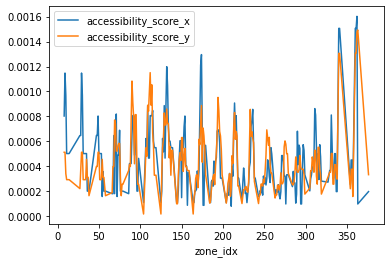

In [132]:
compare_error.sort_values("zone_idx").plot("zone_idx", ["accessibility_score_x", "accessibility_score_y"])

In [148]:
compare_error["minutes_delta"] = compare_error["minutes"] - compare_error["predicted_minutes"]
compare_error["accessibility_delta"] = 1000*(compare_error["accessibility_score_x"] - compare_error["accessibility_score_y"])

compare_error.head()

,zone_idx,day_of_week,dayflag,accessibility_score_x,minutes,accessibility_score_y,predicted_minutes,minutes_delta,accessibility_delta
0,8,3.0,True,0.000803,4.379365,0.000512,4.511531,-0.132166,0.290949
1,9,3.0,True,0.001147,3.173684,0.000512,4.311070,-1.137386,0.635777
2,10,3.0,True,0.000968,4.538889,0.000340,4.312276,0.226613,0.628540
3,11,3.0,True,0.000501,4.251515,0.000292,4.311816,-0.060301,0.209554
4,12,3.0,True,0.000501,5.038095,0.000292,4.313799,0.724296,0.209554


<AxesSubplot:xlabel='zone_idx'>

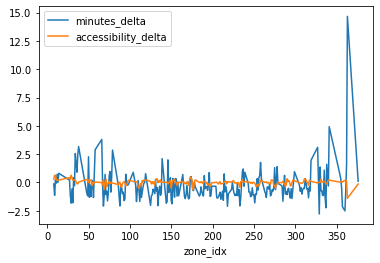

In [149]:
compare_error.sort_values("zone_idx").plot("zone_idx", ["minutes_delta", "accessibility_delta"])

In [150]:


np.sum(np.square(np.array(compare_error["minutes"]) - np.array(compare_error["predicted_minutes"])))



563.2889743634134

In [151]:


np.sum(np.square(np.average(compare_error["minutes"]) - np.array(compare_error["minutes"])))




560.9502704571444

In [152]:
import scipy
scipy.stats.pearsonr(compare_error["minutes_delta"], compare_error["accessibility_delta"])

(-0.20356019790666488, 0.0011045790322543097)